In [1]:
from sklearn import datasets

iris = datasets.load_iris()

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Load the iris dataset
iris = load_iris()
X, y = iris.data, iris.target
class_names = iris.target_names

# Normalize the iris data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

def Tabular_Mask(sample, n_samples=50):
    masks = np.tile(sample, (n_samples, 1))
    for i in range(n_samples):
        feature_to_change = np.random.randint(0, 4)  # Randomly select a feature to change
        min_val = X[:, feature_to_change].min()
        max_val = X[:, feature_to_change].max()
        masks[i, feature_to_change] = np.random.uniform(min_val, max_val)
    return masks

# Split the original (non-normalized) data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
clf.fit(X_train, y_train)


# Take one sample from X (let's use the first sample)
sample_original = X_test[0]
original_class = clf.predict([sample_original])[0]

def create_test_suit(sample, n_samples=100):
    correct_mutants = []
    incorrect_mutants = []
    
    while len(correct_mutants) < n_samples // 2 or len(incorrect_mutants) < n_samples // 2:
        masks = Tabular_Mask(sample, n_samples=10)  # Create 10 mutants at a time
        for mask in masks:
            predicted_class = clf.predict([mask])[0]
            if predicted_class == original_class and len(correct_mutants) < n_samples // 2:
                correct_mutants.append(mask)
            elif predicted_class != original_class and len(incorrect_mutants) < n_samples // 2:
                incorrect_mutants.append(mask)
    
    Test_Suit = np.vstack((correct_mutants[:n_samples//2], incorrect_mutants[:n_samples//2]))
    np.random.shuffle(Test_Suit)  # Shuffle the Test_Suit
    return Test_Suit

# Create the Test_Suit
Test_Suit = create_test_suit(sample_original)

# Print the original sample and its predicted class
print("Original sample:")
print(sample_original)
print(f"Predicted class for original sample: {original_class} ({class_names[original_class]})")

print("\nTest_Suit mutants and their predictions:")
for i, mutant in enumerate(Test_Suit):
    print(f"Mutant {i}:")
    print(mutant)
    predicted_class = clf.predict([mutant])[0]
    print(f"Predicted class: {predicted_class} ({class_names[predicted_class]})")
    print(f"Changed feature: {np.where(mutant != sample_original)[0][0]}")
    print(f"Correctly classified: {predicted_class == original_class}")
    print()

# Count the occurrences of each predicted class in Test_Suit
test_suit_predictions = clf.predict(Test_Suit)
unique, counts = np.unique(test_suit_predictions, return_counts=True)
print("\nPrediction distribution for Test_Suit:")
for class_label, count in zip(unique, counts):
    print(f"Class {class_label} ({class_names[class_label]}): {count} mutants")

# Verify the balance of Test_Suit
correct_count = sum(clf.predict(Test_Suit) == original_class)
print(f"\nCorrectly classified mutants in Test_Suit: {correct_count}")
print(f"Incorrectly classified mutants in Test_Suit: {len(Test_Suit) - correct_count}")

# Print class name mapping for reference
print("\nClass name mapping:")
for i, name in enumerate(class_names):
    print(f"Class {i}: {name}")

# Print feature names for reference
print("\nFeature names:")
for i, name in enumerate(iris.feature_names):
    print(f"Feature {i}: {name}")

Original sample:
[6.1 2.8 4.7 1.2]
Predicted class for original sample: 1 (versicolor)

Test_Suit mutants and their predictions:
Mutant 0:
[6.1        3.88696504 4.7        1.2       ]
Predicted class: 1 (versicolor)
Changed feature: 1
Correctly classified: True

Mutant 1:
[6.1        2.8        2.13958277 1.2       ]
Predicted class: 0 (setosa)
Changed feature: 2
Correctly classified: False

Mutant 2:
[6.1        2.20125836 4.7        1.2       ]
Predicted class: 1 (versicolor)
Changed feature: 1
Correctly classified: True

Mutant 3:
[6.1        2.8        4.7        2.31235661]
Predicted class: 2 (virginica)
Changed feature: 3
Correctly classified: False

Mutant 4:
[6.1        2.8        3.21200339 1.2       ]
Predicted class: 1 (versicolor)
Changed feature: 2
Correctly classified: True

Mutant 5:
[6.1        2.8        4.7        2.48775114]
Predicted class: 2 (virginica)
Changed feature: 3
Correctly classified: False

Mutant 6:
[7.47327891 2.8        4.7        1.2       ]
Predicte

In [3]:
def calculate_feature_relevance(Test_Suit, sample_original, clf):
    n_features = len(sample_original)
    Et = np.zeros(n_features)
    Ef = np.zeros(n_features)
    Nt = np.zeros(n_features)
    Nf = np.zeros(n_features)

    original_prediction = clf.predict([sample_original])[0]

    for mutant in Test_Suit:
        mutant_prediction = clf.predict([mutant])[0]
        for feature in range(n_features):
            if mutant[feature] == sample_original[feature]:
                if mutant_prediction == original_prediction:
                    Et[feature] += 1
                else:
                    Ef[feature] += 1
            else:
                if mutant_prediction == original_prediction:
                    Nt[feature] += 1
                else:
                    Nf[feature] += 1

    return Et, Ef, Nt, Nf

# Calculate feature relevance
Et, Ef, Nt, Nf = calculate_feature_relevance(Test_Suit, sample_original, clf)

In [4]:
# Calculate Wong1 feature importance
def calculate_ochiai(Ef, Ep, Nf, Np):
    numerator = Ef
    denominator = np.sqrt((Ef + Nf) * (Ef + Ep))
    return np.divide(numerator, denominator, where=denominator!=0)

def calculate_tarantula(Ef, Ep, Nf, Np):
    numerator = np.divide(Ef, Ef + Nf, where=(Ef + Nf)!=0)
    denominator = numerator + np.divide(Ep, Ep + Np, where=(Ep + Np)!=0)
    return np.divide(numerator, denominator, where=denominator!=0)

def calculate_zoltar(Ef, Ep, Nf, Np):
    epsilon = 1e-10  # Small value to prevent division by zero
    return Ef / (Ef + Nf + Ep + (10000 * Nf * Ep / (Ef + epsilon)))

def calculate_wong1(Et, Ef):
    return Et - Ef

formulas = {
    "Wong1": calculate_wong1(Et, Ef),
    "Ochiai": 1- calculate_ochiai(Ef, Et, Nf, Nt),
    "Tarantula": 1- calculate_tarantula(Ef, Et, Nf, Nt),
    "Zoltar": 1- calculate_zoltar(Ef, Et, Nf, Nt)
}


# Normalize scores for each formula
normalized_formulas = {}
for formula_name, scores in formulas.items():
    normalized_scores = (scores - np.min(scores)) / (np.max(scores) - np.min(scores))
    normalized_formulas[f"{formula_name}_normalized"] = normalized_scores

# Combine raw and normalized scores
all_scores = {**formulas, **normalized_formulas}

# Print feature importance for each formula
for formula_name, scores in all_scores.items():
    print(f"\n{formula_name} Feature Importance:")
    for i, feature_name in enumerate(iris.feature_names):
        print(f"{feature_name}: {scores[i]:.4f}")

    # Sort features by importance
    sorted_indices = np.argsort(scores)[::-1]
    print(f"\nFeatures sorted by {formula_name} importance (most to least important):")
    for i in sorted_indices:
        print(f"{iris.feature_names[i]}: {scores[i]:.4f}")

# Prepare the data for plotting
data = [
    {
        "name": iris.feature_names[i],
        **{f"{formula_name}": scores[i] for formula_name, scores in all_scores.items()}
    }
    for i in range(len(iris.feature_names))
]

print("\nData prepared for plotting:")
print(data)


Wong1 Feature Importance:
sepal length (cm): -20.0000
sepal width (cm): -14.0000
petal length (cm): 19.0000
petal width (cm): 15.0000

Features sorted by Wong1 importance (most to least important):
petal length (cm): 19.0000
petal width (cm): 15.0000
sepal width (cm): -14.0000
sepal length (cm): -20.0000

Ochiai Feature Importance:
sepal length (cm): 0.2094
sepal width (cm): 0.2375
petal length (cm): 0.6080
petal width (cm): 0.5301

Features sorted by Ochiai importance (most to least important):
petal length (cm): 0.6080
petal width (cm): 0.5301
sepal width (cm): 0.2375
sepal length (cm): 0.2094

Tarantula Feature Importance:
sepal length (cm): 0.3750
sepal width (cm): 0.4186
petal length (cm): 0.6508
petal width (cm): 0.6056

Features sorted by Tarantula importance (most to least important):
petal length (cm): 0.6508
petal width (cm): 0.6056
sepal width (cm): 0.4186
sepal length (cm): 0.3750

Zoltar Feature Importance:
sepal length (cm): 0.3750
sepal width (cm): 0.4186
petal length (

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed
from IPython.display import display
import os

def plot_feature_importance(data, view='Raw', measure='Wong1', save=False):
    fig, ax = plt.subplots(figsize=(14, 8))


    # Sort data by absolute raw importance of the selected measure
    sorted_data = sorted(data, key=lambda x: abs(x['Wong1']), reverse=True)
    names = [item['name'] for item in sorted_data]
    index = np.arange(len(names))

    # Use coolwarm colormap
    cmap = plt.get_cmap('coolwarm')

    values = [item[f'{measure}{"" if view == "Raw" else "_normalized"}'] for item in sorted_data]
    
    # Create a normalize object for this measure
    if view == 'Raw':
        norm = Normalize(vmin=min(values), vmax=max(values))
    else:
        norm = Normalize(vmin=0, vmax=1)
    
    # Map each value to a color
    colors = [cmap(norm(value)) for value in values]
    
    # Plot the bars
    bars = ax.barh(index, values, 0.8, label=measure, color=colors, alpha=0.7)
    
    # Add a colorbar for this measure
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)


    ax.set_yticks(index)
    ax.set_yticklabels(names)

    ax.set_xlabel('Feature Score')

    if view == 'Raw':
        ax.axvline(x=0, color='gray', linestyle='--')
    else:
        ax.set_xlim(0, 1)

    plt.tight_layout()
    
    if save:
        # Create a directory for saving plots if it doesn't exist
        save_dir = 'raw_importance_plots'
        os.makedirs(save_dir, exist_ok=True)
        
        # Save the plot
        filename = f'{measure}_raw_importance.png'
        filepath = os.path.join(save_dir, filename)
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        plt.close(fig)
        print(f"Saved plot: {filepath}")
    else:
        plt.show()

# Create interactive widgets
view_widget = widgets.RadioButtons(options=['Raw', 'Normalized'], description='View:')
measure_widget = widgets.RadioButtons(
    options=['Wong1', 'Ochiai', 'Tarantula', 'Zoltar'],
    description='Measure:'
)

# Combine widgets
widgets_combined = widgets.VBox([view_widget, measure_widget])

# Create interactive plot
interactive_plot = interactive(plot_feature_importance,
                               data=fixed(data),
                               view=view_widget,
                               measure=measure_widget,
                               save=fixed(False))

# Display widgets and plot
display(widgets_combined, interactive_plot.children[-1])

# Save all plots for Raw Importance
measures = ['Wong1', 'Ochiai', 'Tarantula', 'Zoltar']

for measure in measures:
    plot_feature_importance(data, view='Raw', measure=measure, save=True)

print("All Raw Importance plots have been saved.")

Output()

Saved plot: raw_importance_plots\Wong1_raw_importance.png
Saved plot: raw_importance_plots\Ochiai_raw_importance.png
Saved plot: raw_importance_plots\Tarantula_raw_importance.png
Saved plot: raw_importance_plots\Zoltar_raw_importance.png
All Raw Importance plots have been saved.


TypeError: plot_feature_importance() got an unexpected keyword argument 'ax'

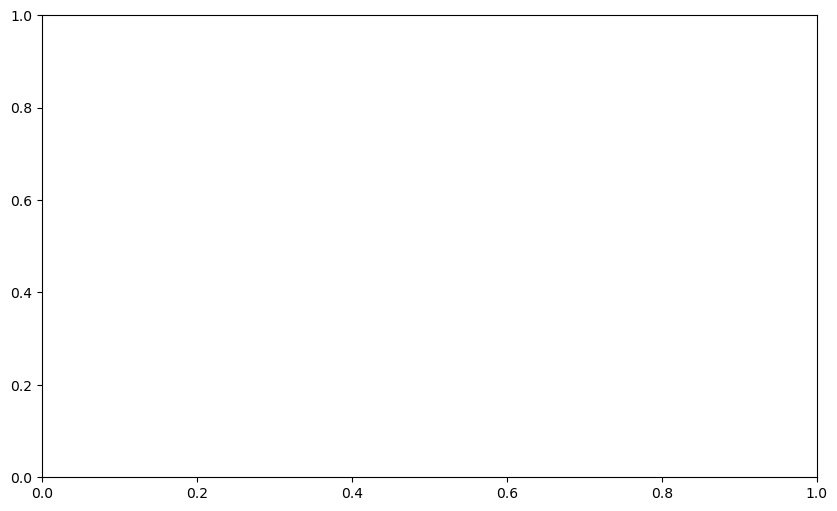

In [7]:
# Save all plots for Raw Importance
measures = ['Wong1', 'Ochiai', 'Tarantula', 'Zoltar']

for measure in measures:
    fig, ax = plt.subplots(figsize=(10, 6))
    plot_feature_importance(data, view='Raw', measure=measure, ax=ax)
    
    # Create a directory for saving plots if it doesn't exist
    save_dir = 'raw_importance_plots'
    os.makedirs(save_dir, exist_ok=True)
    
    # Save the plot
    filename = f'{measure}_raw_importance.png'
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.close(fig)
    print(f"Saved plot: {filepath}")

print("All Raw Importance plots have been saved.")
